In [1]:

%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [86]:
import os
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import random
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
import time



%matplotlib inline

## Step 0: Load The Data

In [3]:
cars_dir =     './vehicles/*/*.png'
notcars_dir = './non-vehicles/*/*.png'
testimages_dir = './test_images/*.jpg'

cars_fnames = []
notcars_fnames = []
testimages_fnames = []
cars = []
notcars = []
testimages = []

i = 0
images = glob.glob(cars_dir)
for img_path in images:
    cars_fnames.append(img_path)
    img = cv2.imread(img_path)
    cars.append(img)
        
images = glob.glob(notcars_dir)
for img_path in images:
    notcars_fnames.append(img_path)
    img = cv2.imread(img_path)
    notcars.append(img)
    
images = glob.glob(testimages_dir)
for img_path in images:
    testimages_fnames.append(img_path)
    img = cv2.imread(img_path)
    testimages.append(img)

## Step 1: Dataset Summary & Visualization

In [4]:
n_cars = len(cars)
n_notcars = len(notcars)
image_shape = cars[0].shape

print('Number of car examples =', n_cars)
print('Number of not car examples =', n_notcars)
print('Image data shape =', image_shape)


Number of car examples = 8792
Number of not car examples = 8968
Image data shape = (64, 64, 3)


In [5]:
def plot_images_in_column(input_images, num_cols, figure_name, cmap = None):
    fig, axes = plt.subplots((int)((len(input_images) + 1) /num_cols), num_cols, figsize=(24, 20))
    fig = plt.gcf()
    fig.canvas.set_window_title(figure_name)
    
    print(figure_name)
    
    for ax, image in zip(axes.flat, input_images):
        if(cmap == "gray" or cmap == 'hot'):
            ax.imshow(image, cmap=cmap)
        elif(image.shape[2]==1):
            ax.imshow(image[:,:,0], cmap = cmap)
        else:
            ax.imshow(image, cmap=cmap)

    plt.show()

Cars


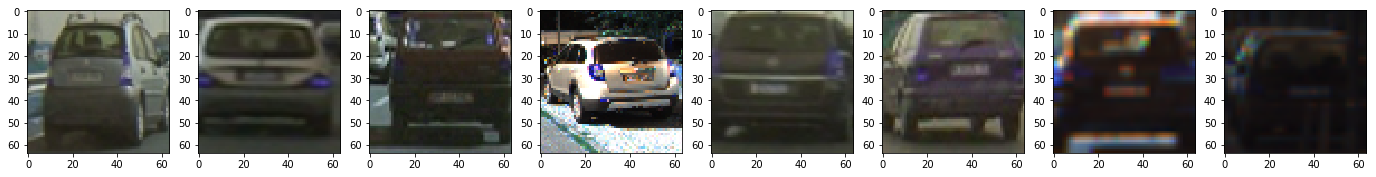

Not cars


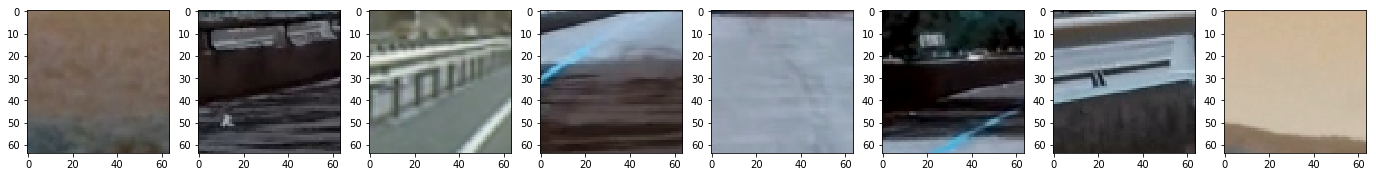

In [6]:
num_images = 8
car_samples = random.sample(list(cars), num_images)
notcar_samples = random.sample(list(notcars), num_images)

car_images = []
notcar_images = []
for sample in car_samples:
    car_images.append(sample)
for sample in notcar_samples:
    notcar_images.append(sample)

plot_images_in_column(car_images, num_images, 'Cars')
plot_images_in_column(notcar_images, num_images, 'Not cars')

From the sample images, car images have picture of cars from the back or the side from various angles.  The lighting seems to be differ a lot, with some images look to be with a lot of sun lights while others are images from the darkness.

# Step 2: Visualize color spaces

In [7]:
def plot3d_colorspaces(img, ptitle):
    
    print('------- ', ptitle)
    fig_img = plt.figure(figsize=(3,3))
    ax0 = fig_img.add_subplot(1,1,1)
    ax0.imshow(img, cmap=None)
    
    # Select a small fraction of pixels to plot by subsampling it
    scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

    # Convert subsampled image to desired color space(s)
    img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
    img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
    img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
    img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCrCb)
    img_small_YUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2YUV)
    img_small_LUB = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
    img_small_GRAY = cv2.cvtColor(img_small, cv2.COLOR_BGR2GRAY)

    img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

    # Create figure and 3D axes
    
    # figure parameters
    fig = plt.figure(figsize=(15, 8))
    fontsize = 12
    labelsize = 10
    pad = 6
    labelpad = 8

    def set_ax1(ax_lim):
        # Set axis limits
        ax1.set_xlim(*ax_lim[0])
        ax1.set_ylim(*ax_lim[1])
        ax1.set_zlim(*ax_lim[2])
        # Set axis labels and sizes
        ax1.tick_params(axis='both', which='major', labelsize=labelsize, pad=pad)
        ax1.set_xlabel(axis_labels[0], fontsize=fontsize, labelpad=labelpad)
        ax1.set_ylabel(axis_labels[1], fontsize=fontsize, labelpad=labelpad)
        ax1.set_zlabel(axis_labels[2], fontsize=fontsize, labelpad=labelpad)
        # Plot pixel values with colors given in colors_rgb
        ax1.scatter(
            pixels[:, :, 0].ravel(),
            pixels[:, :, 1].ravel(),
            pixels[:, :, 2].ravel(),
            c=img_small_rgb.reshape((-1, 3)), edgecolors='none')
        
    
    # RGB
    ax1 = fig.add_subplot(2,3,1,projection='3d')
    axis_limits=((0, 255), (0, 255), (0, 255))
    axis_labels=list('RGB')
    ax1.set_title('RGB')
    pixels=img_small_RGB
    set_ax1(ax_lim=axis_limits)
    
    # HLS
    ax1 = fig.add_subplot(2,3,2,projection='3d')
    axis_limits=((0, 255), (0, 255), (0, 255))
    axis_labels=list('HLS')
    pixels=img_small_HLS
    set_ax1(ax_lim=axis_limits)

    # HSV
    ax1 = fig.add_subplot(2,3,3,projection='3d')
    axis_limits=((0, 255), (0, 255), (0, 255))
    axis_labels=list('HSV')
    ax1.set_title('HSV')
    pixels=img_small_HSV
    set_ax1(ax_lim=axis_limits)

    # YCrCb
    ax1 = fig.add_subplot(2,3,4,projection='3d')
    axis_limits=((0, 255), (0, 255), (0, 255))
    axis_labels=list('Yrb')
    ax1.set_title('YCrCb')
    pixels=img_small_YCrCb
    set_ax1(ax_lim=axis_limits)

    # YUV
    ax1 = fig.add_subplot(2,3,5,projection='3d')
    axis_limits=((0, 255), (0, 255), (0, 255))
    axis_labels=list('YUV')
    ax1.set_title('YUV')
    pixels=img_small_YUV
    set_ax1(ax_lim=axis_limits)

    # LUB
    ax1 = fig.add_subplot(2,3,6,projection='3d')
    axis_limits=((0, 255), (0, 255), (0, 255))
    axis_labels=list('LUB')
    ax1.set_title('LUB')
    pixels=img_small_LUB
    set_ax1(ax_lim=axis_limits)
    
    
    plt.show()

    return None  

-------  Car Image 1073


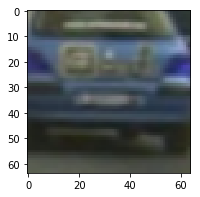

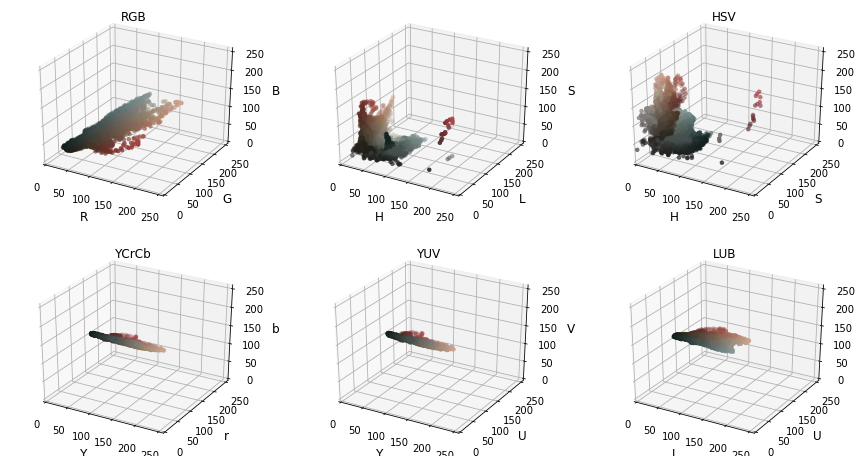

-------  Notcar Image 1850


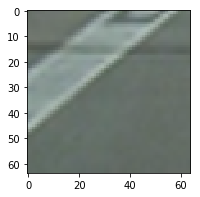

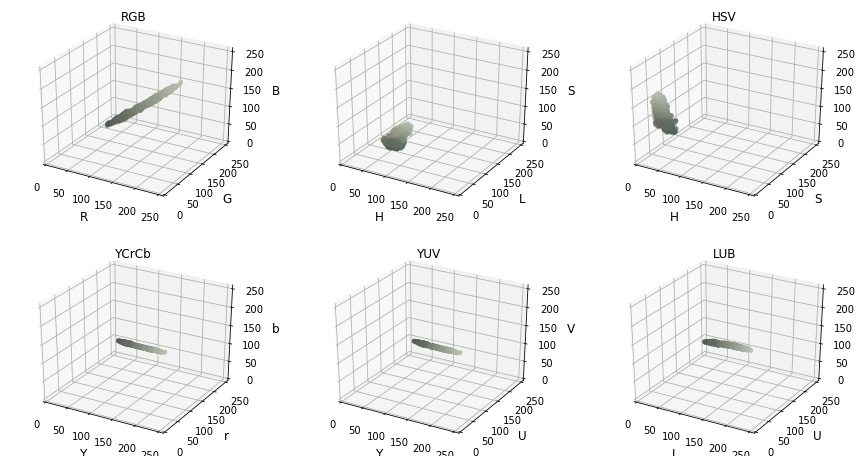

-------  Car Image 8020


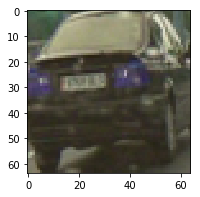

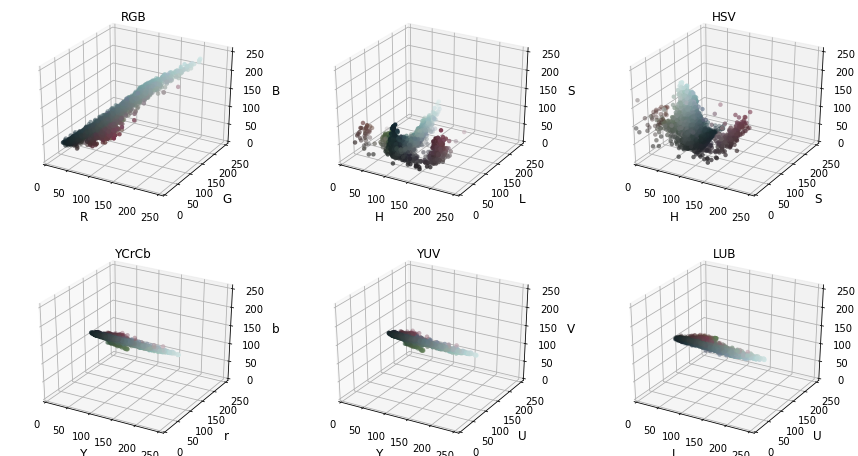

-------  Notcar Image 4879


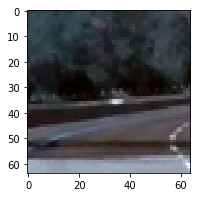

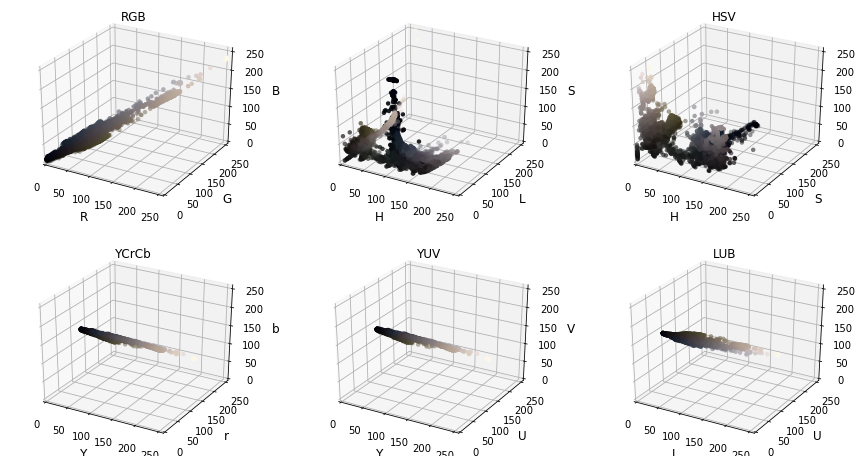

-------  Car Image 1943


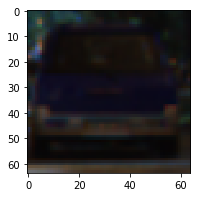

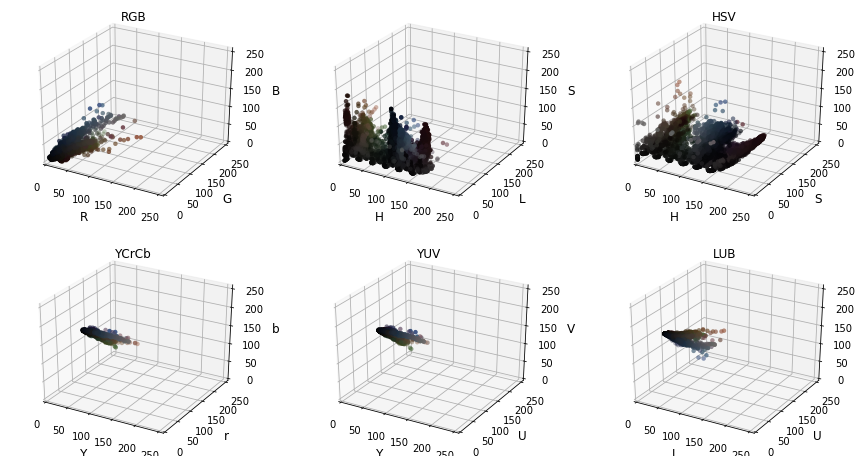

-------  Notcar Image 629


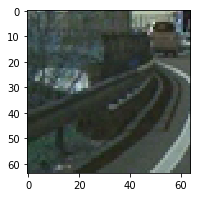

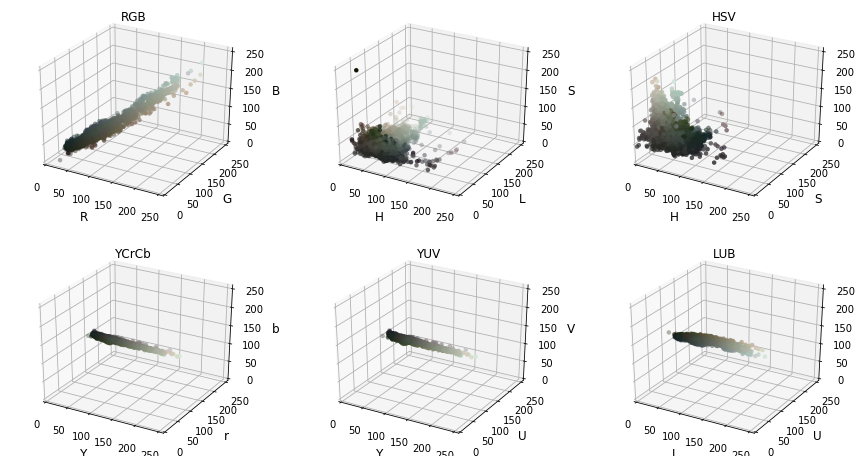

In [8]:
for i in range(3):
    num = random.randint(0,len(cars)-1)
    plot3d_colorspaces(cars[num], 'Car Image ' + str(num))
    
    num = random.randint(0,len(notcars)-1)
    plot3d_colorspaces(notcars[num], 'Notcar Image ' + str(num))

One thing I noticed was that YCrCb and YUV were nearly identical in most images.  Through iterations, they seem to produce most distinguishiable features.  At the end, YCrCb was used to separate car images from non-car images.

In [9]:
def plot_YCrCb(img, img_name):
    
    print(img_name)
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    fig = plt.figure(figsize=(15,10))
    plt.subplot(151)
    plt.imshow(img)
    plt.title('Orig Image')
    plt.subplot(152)
    plt.imshow(img_YCrCb[:,:,0], cmap='gray')
    plt.title('Y channel')
    plt.subplot(153)
    plt.imshow(img_YCrCb[:,:,1], cmap='gray')
    plt.title('Cr channel')
    plt.subplot(154)
    plt.imshow(img_YCrCb[:,:,2], cmap='gray')
    plt.title('Cb channel')
    plt.subplot(155)
    plt.imshow(img_YCrCb)
    plt.title('YCrCb Image')
    plt.show()

Car Image 7593


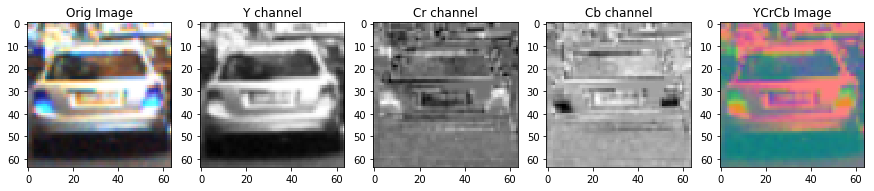

Car Image 6567


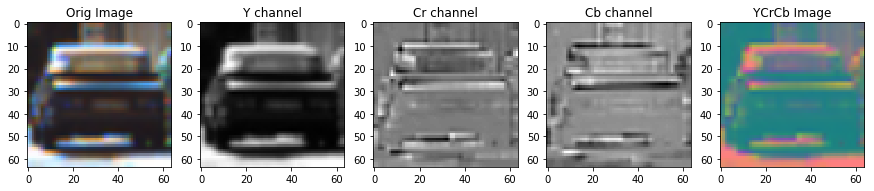

Car Image 3535


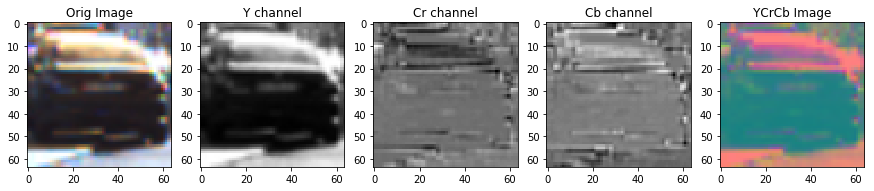

In [10]:
for i in range(3):
    num = random.randint(0,len(cars)-1)
    plot_YCrCb(cars[num], 'Car Image ' + str(num))

## Step 3: visualize HOG features

In [11]:

def get_hog_features_old(img, orient, pix_per_cell, cell_per_block, vis=True,
                     feature_vec=True):
                         
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    # name returns explicitly
    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features

In [12]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [142]:
def plot_hog_features(img, img_name):
    pix_per_cell = 8
    cell_per_block = 2
    orient = 9

    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    features_h, img_hog = get_hog_features(img_ycrcb[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    
    print(img_name)
    fig = plt.figure(figsize=(8,3))
    plt.subplot(131)
    plt.imshow(img)
    plt.title('Orig Image')
    plt.subplot(132)
    plt.imshow(img_ycrcb)
    plt.title('YCrCb image')
    plt.subplot(133)
    plt.imshow(img_hog, cmap='gray')
    plt.title('hog image')
    plt.show()    

Car Image 7791


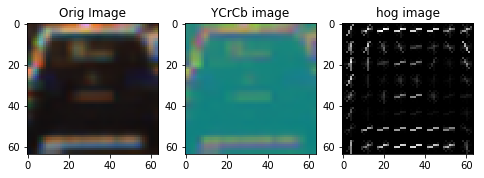

Not car Image 4638


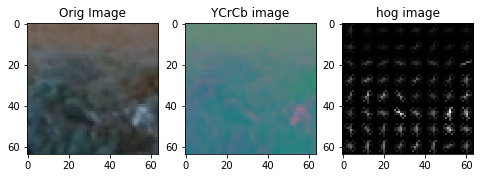

Car Image 8145


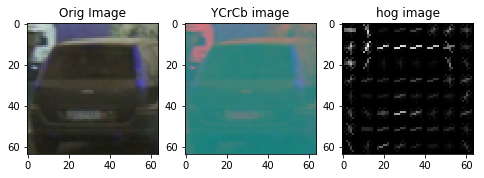

Not car Image 6328


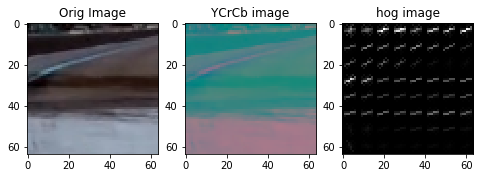

In [143]:
for i in range(2):
    num = random.randint(0,len(cars)-1)
    plot_hog_features(cars[num], 'Car Image ' + str(num))
    num = random.randint(0,len(notcars)-1)
    plot_hog_features(notcars[num], 'Not car Image ' + str(num))

## Step 4: Train SVM after combining and normalizing features

In [15]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial_old1(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [16]:
def bin_spatial_old2(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [17]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [18]:
# Define a function to compute color histogram features  
def color_hist_old(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [19]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [20]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_old(imgs, cspace='RGB', spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256),
                     orient=9, pix_per_cell=8, cell_per_block=2):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
#        print(file)
        # Read in each one by one
#        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # get hog_features
        hog_features = []
        for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)

        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

In [23]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [24]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

t=time.time()

car_features = extract_features(cars_fnames, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars_fnames, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)



t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
print(X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print(len(y))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
#X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
#X_train = X_scaler.transform(X_train)
#X_test = X_scaler.transform(X_test)

#X_train, X_test = shuffle(X_train, y_train, random_state=rand_state)
# # Compute a PCA  on the features 
# n_components = 4932

# print("Extracting the top %d features from %d total features"
#       % (n_components, X_train.shape[1]))

# pca = PCA(n_components=n_components, svd_solver='randomized',
#           whiten=True).fit(X_train)

# X_train_pca = pca.transform(X_train)
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC X_scaler
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

199.55 Seconds to extract HOG features...
(17760, 8460)
17760
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
31.14 Seconds to train SVC...


In [25]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9817
My SVC predicts:  [ 1.  1.  1.  1.  0.  1.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  0.  1.  1.  0.  1.  1.]
0.00417 Seconds to predict 10 labels with SVC


In [26]:
#data_file = '../CarND-Vehicle-Detection/svc_pickle.p'
data_file = './svc_pickle.p'

if not os.path.isfile(data_file):
    with open(data_file, 'wb') as pfile:
        pickle.dump(
            {
                'svc': svc,
                'scaler': X_scaler,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins
                
            },
            pfile, pickle.HIGHEST_PROTOCOL)

print('Data saved in pickle file')

Data saved in pickle file


## step 5: sliding window

In [27]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [28]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

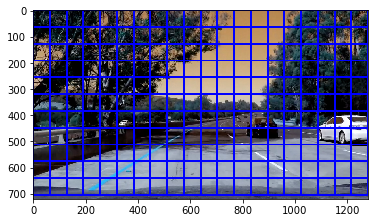

In [35]:
image = testimages[0]

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

In [36]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [37]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

./test_images/test5.jpg


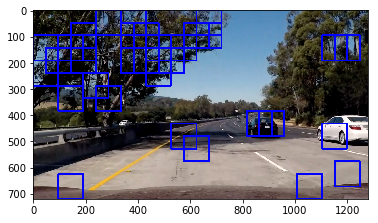

./test_images/test1.jpg


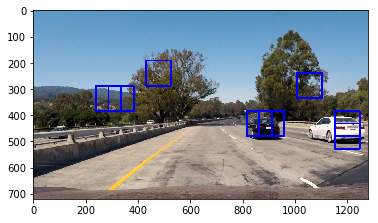

./test_images/test6.jpg


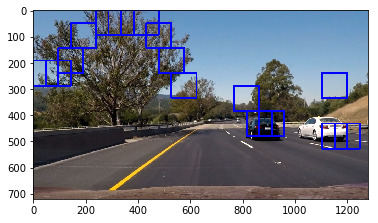

./test_images/test2.jpg


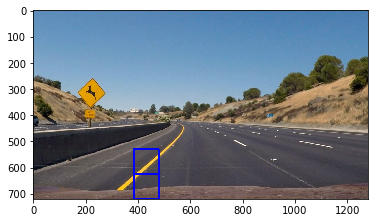

./test_images/test4.jpg


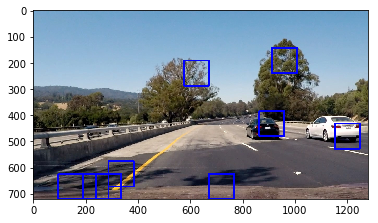

./test_images/test3.jpg


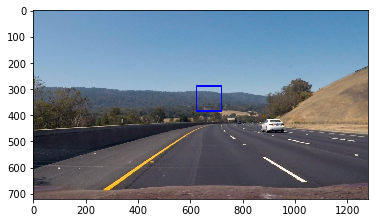

In [38]:

for fname in testimages_fnames:

    print(fname)
    plt.figure()
    
    image = mpimg.imread(fname)
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

    plt.imshow(window_img)
    plt.show()
    
    

In [39]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'BGR2YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)


In [147]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
#    xstart = int(img.shape[1]/5)
#    xstop = img.shape[1]
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    boxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1, -1)
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1, -1)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size).reshape(1, -1)
            hist_features = color_hist(subimg, nbins=hist_bins).reshape(1, -1)

#            print(hog_features.shape)
#            print(spatial_features.shape)
#            print(hist_features.shape)
            
            # Scale features and make a prediction
#            test_features = X_scaler.transform(hog_features)    
#            test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
#            print(test_prediction)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, boxes

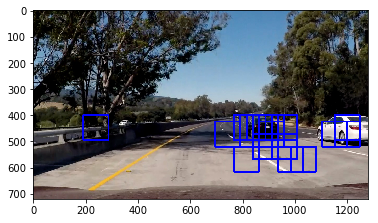

In [148]:
# load a pe-trained svc model from a serialized (pickle) file
dist_pickle = pickle.load( open("../CarND-Vehicle-Detection/svc_pickle.p", "rb" ) )

# get attributes of our svc object
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

img = mpimg.imread(testimages_fnames[0])
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img, boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                           cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

In [210]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
#        print(box)
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [150]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [151]:
def draw_labeled_bboxes(img, labels):
    img_copy = np.copy(img)
    out_rectangles = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        area = (bbox[1][1] - bbox[0][1]) * (bbox[1][0] - bbox[0][0])
        if area > 40 * 40:
            out_rectangles.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, out_rectangles

In [152]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [ ]:
def get_bboxes_old(image, display=False, scales=[1, 1.5, 2, 2.5, 3], 
                     ystarts=[400, 400, 450, 450, 460], ystops=[528, 550, 620, 650, 700]):

    out_rectangles = []
    for scale, ystart, ystop in zip(scales, ystarts, ystops):
        out_img, rectangles = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                               spatial_size, hist_bins)
        if len(rectangles) > 0:
            out_rectangles.append(rectangles)
    out_rectangles = [item for sublist in out_rectangles for item in sublist] 

    if display:
        plt.figure(figsize=(10,6))
        plt.imshow(draw_boxes(image, out_rectangles, color=(0, 0, 255), thick=1))
    
    return out_rectangles

In [179]:
def get_bboxes(image, display=False):

    out_rectangles = []
    
    y_start_stop = [400, 656]
    scale_range=[1,2]
    scale_steps=1
    
    for scale in np.linspace(scale_range[0], scale_range[1], scale_steps):
        print(scale)
        print(spatial_size)
        out_img, rectangles = find_cars(image, y_start_stop[0], y_start_stop[1], 
                            scale, svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins)
        if len(rectangles) != 0:
            out_rectangles.append(rectangles)
    out_rectangles = [item for sublist in out_rectangles for item in sublist] 

    if display:
        plt.figure(figsize=(10,6))
        plt.imshow(draw_boxes(image, out_rectangles, color=(0, 0, 255), thick=1))
    
    return out_rectangles

1.0
(32, 32)


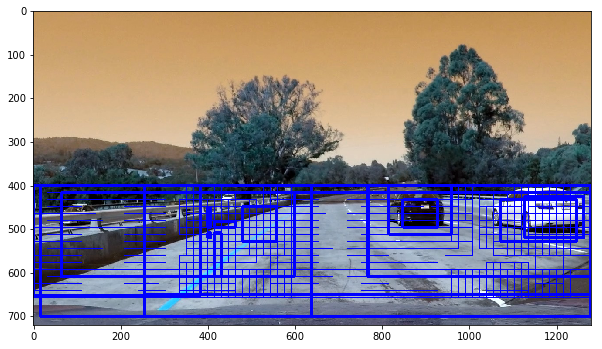

In [180]:
tmp1 = get_bboxes(testimages[1], display=True)

In [155]:
def plot_images(input_images, num_cols, figure_name, cmap = None):
    "Shows input images by stacking them in num_cols columns"
    fig, axes = plt.subplots((int)((len(input_images) + 1) /num_cols), num_cols, figsize=(24, 20))

    fig = plt.gcf()
    fig.canvas.set_window_title(figure_name)
    
    print(figure_name)
    
    for ax, image in zip(axes.flat, input_images):
        if(cmap == "gray" or cmap == 'hot'):
            ax.imshow(image, cmap=cmap)
        elif(image.shape[2]==1):
            ax.imshow(image[:,:,0], cmap = cmap)
        else:
            ax.imshow(image, cmap=cmap)

    plt.show()

In [162]:
threshold = 1

result_images = []
result_boxes = []
heatmap_images = []
result_img_all_boxes = []
for image in testimages:
    rectangles = get_bboxes(image, display=False)
    result_img_all_boxes.append(draw_boxes(image, rectangles, color=(0,0,255), thick=3))

    heatmap_image = np.zeros_like(image[:, :, 0])
    heatmap_image = add_heat(heatmap_image, rectangles)
    heatmap_images.append(heatmap_image)
    heatmap_image = apply_threshold(heatmap_image, threshold)
    labels = label(heatmap_image)

    result_image, rectangles  = draw_labeled_bboxes(image, labels)
    result_boxes.append(rectangles)
    result_images.append(result_image)

check


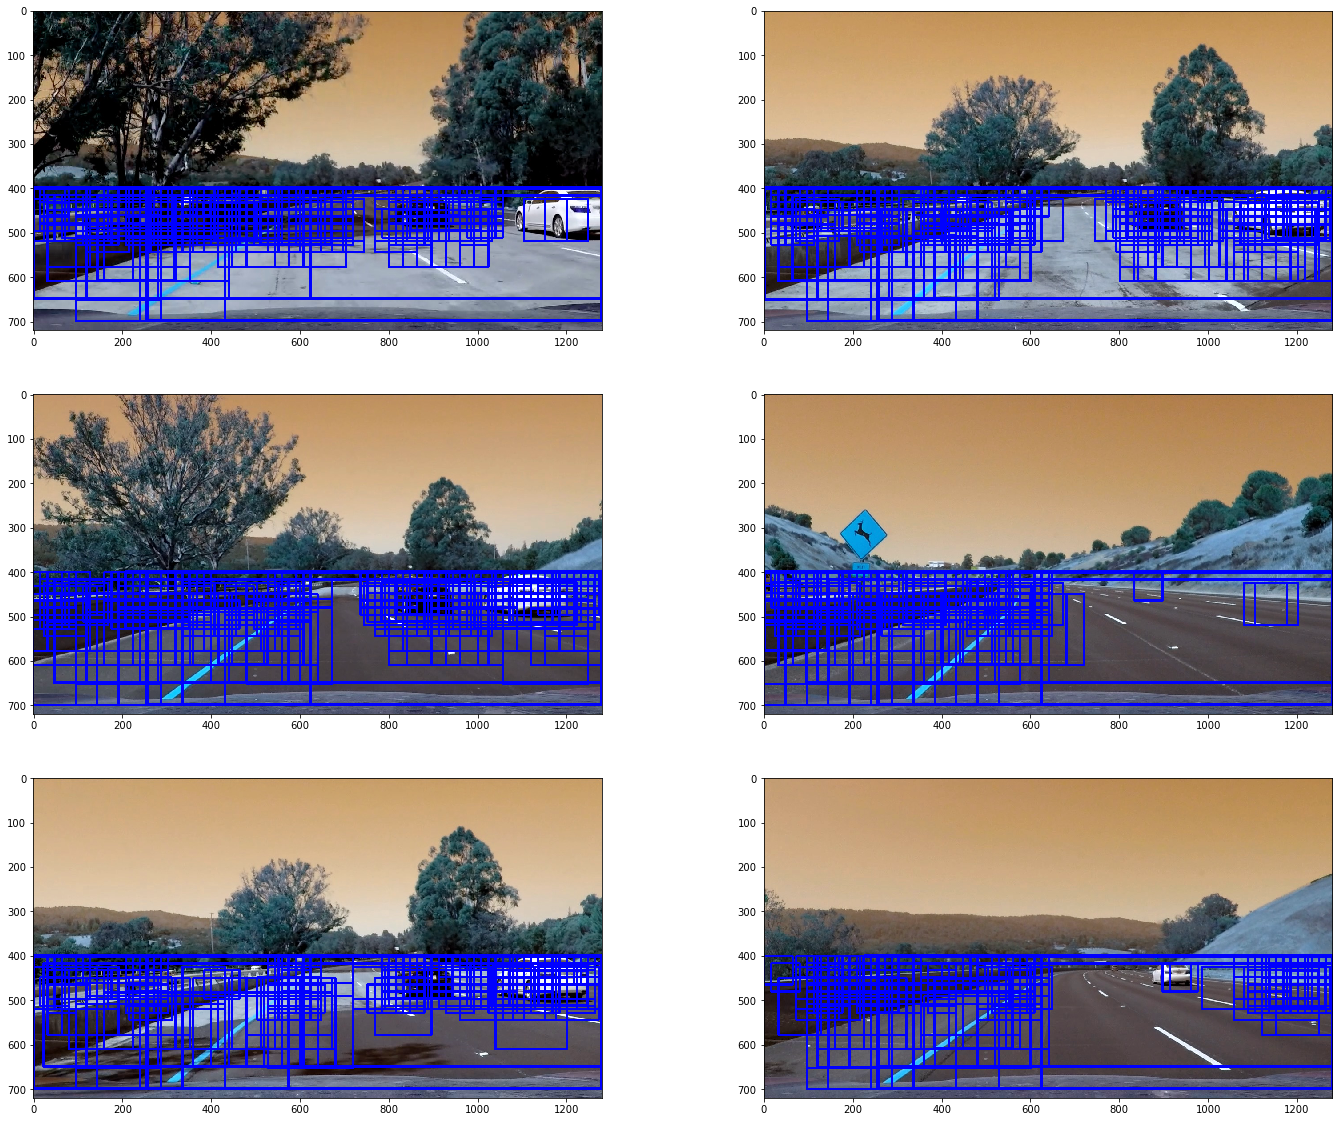

In [163]:
plot_images(result_img_all_boxes, 2, 'check')

check


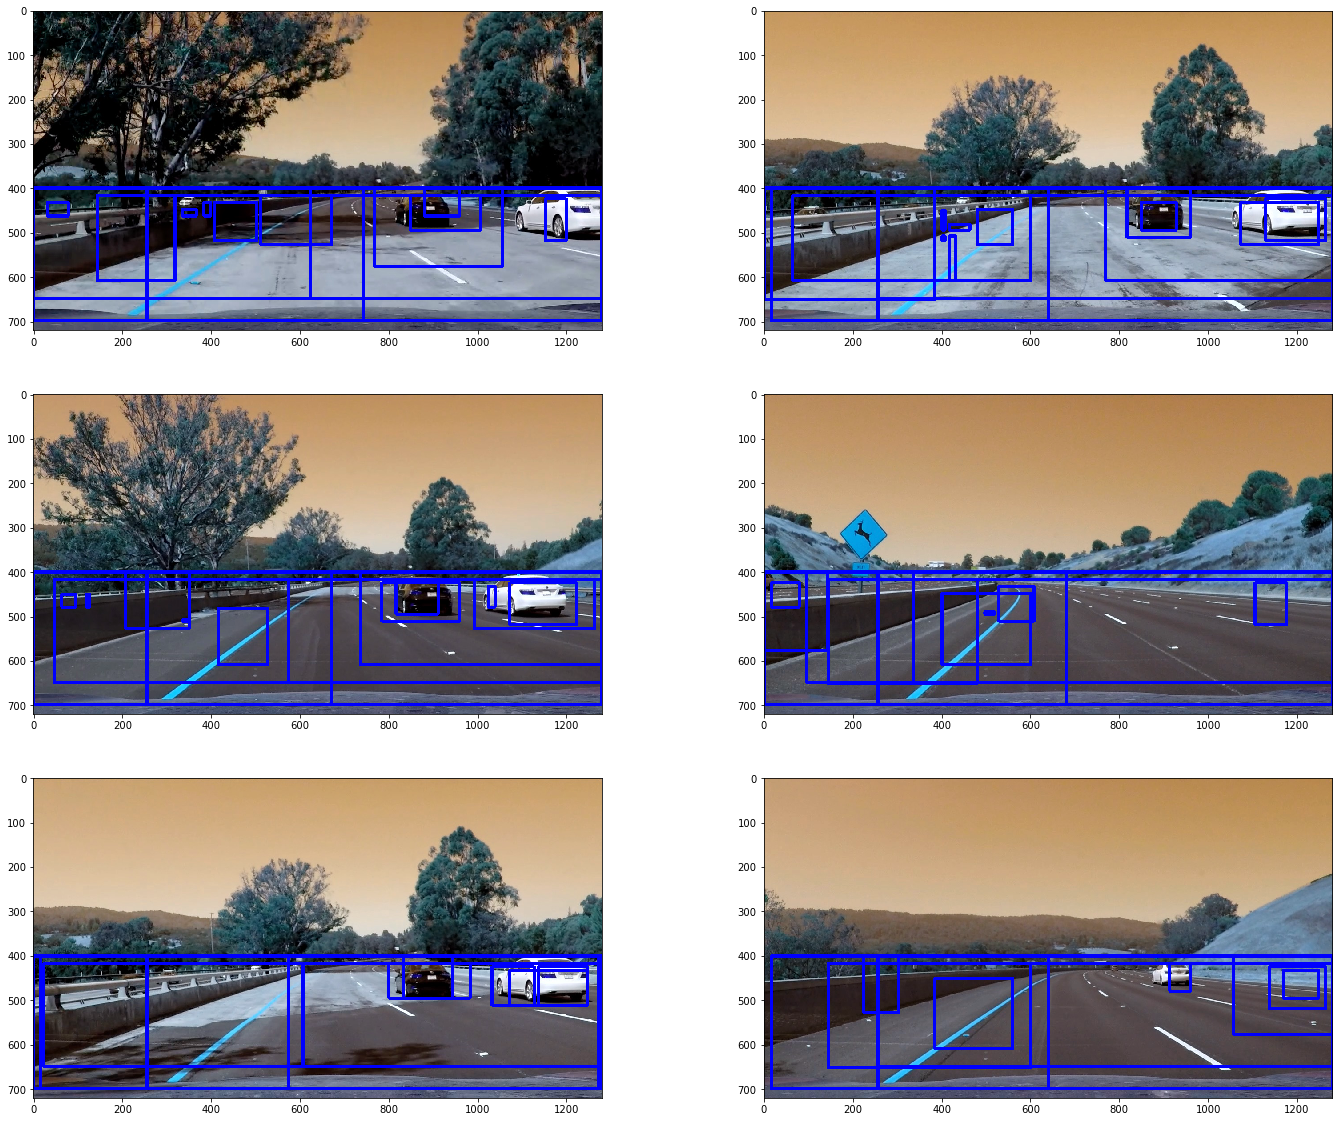

In [164]:
plot_images(result_images, 2, 'check')

heatmap


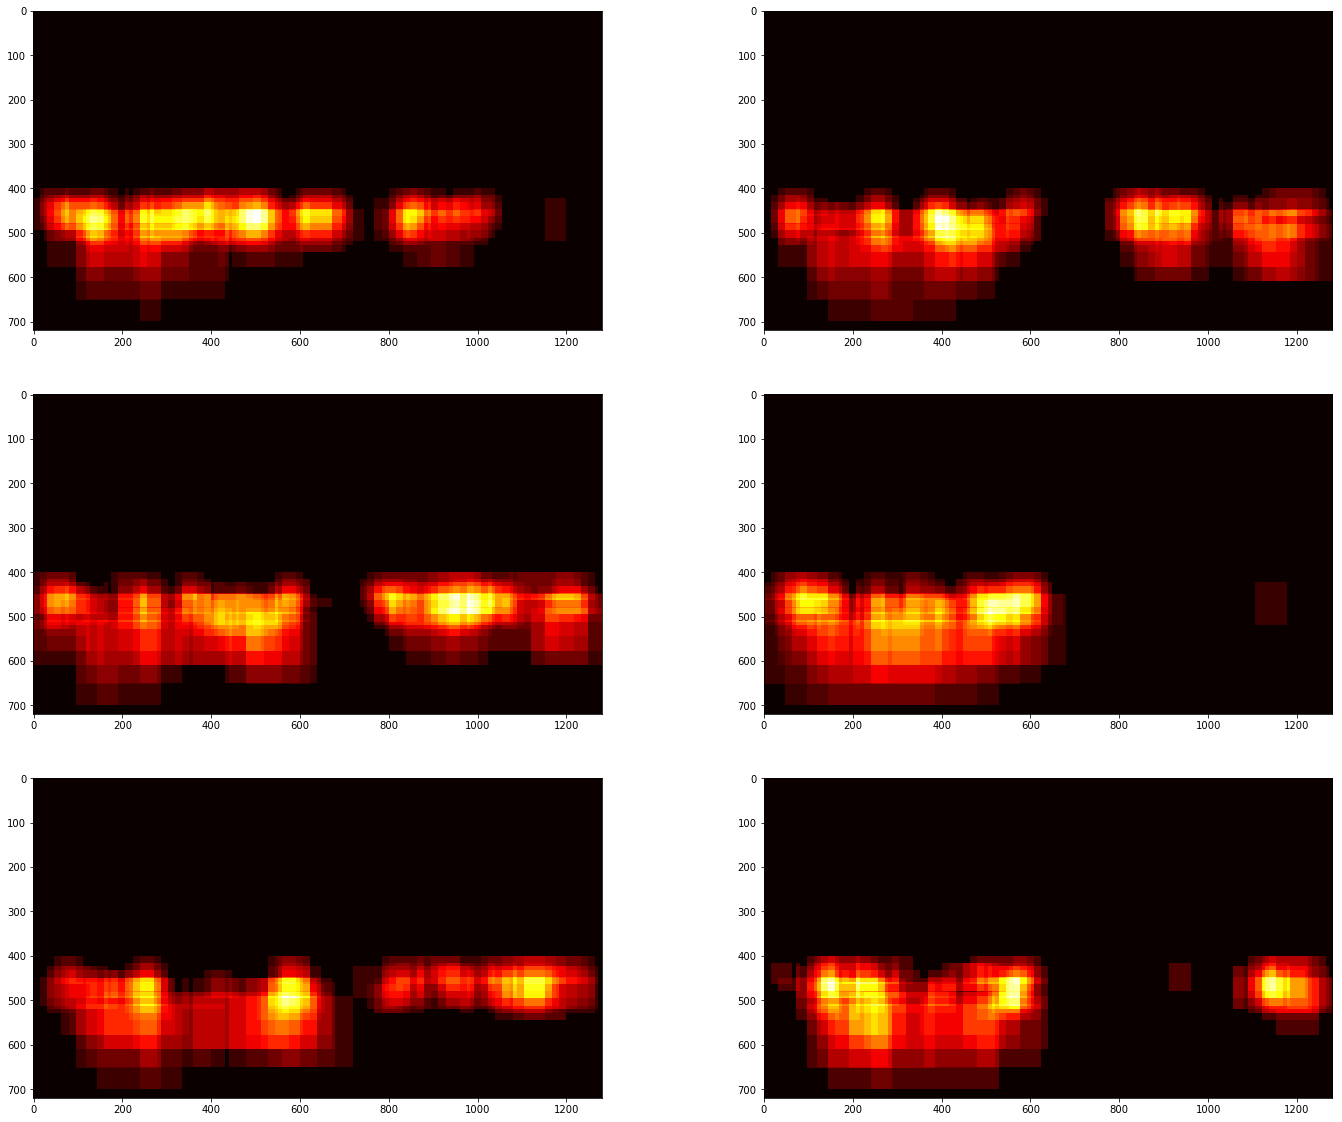

In [183]:
plot_images(heatmap_images, 2, 'heatmap', cmap='hot')

In [184]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import queue

In [219]:
def video_pipeline(img, out_heatmap=False):

    color_space = 'YCrCb'
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    spatial_size = (32,32)
    hist_bins = 32
    spatial_feat = True
    hist_feat = True
    hog_feat = True
    y_start_stop = [400, 656]
    scale_range = [1, 2]
    scale_steps = 5
    heat_thresh = 1
    #for scale in np.linspace(scale_range[0], scale_range[1], scale_steps):
    t = time.time()
    detected = []
    for scale in np.linspace(scale_range[0], scale_range[1], scale_steps):
#        print('video_pipeline scale ', scale)
        tmpimg, boxes = find_cars(img, y_start_stop[0], y_start_stop[1], 
                            scale, svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins)
        if len(boxes) != 0:
            detected.append(boxes)

    if len(detected) >0:
        detected = np.concatenate(detected)
    
#    print('len detected before heatmap', len(detected))
    heatmap = np.zeros_like(img[:,:,0])
    heatmap = add_heat(heatmap, detected)
    heatmap = apply_threshold(heatmap, heat_thresh)

    labels = label(heatmap)
    outimg, tmp2 = draw_labeled_bboxes(np.copy(img), labels)
    #print ('run time is: '+ str(time.time() - t))
    if out_heatmap == True:
        return outimg, heatmap
    else:
        return outimg

In [220]:
output_video = './out_video.mp4'
input_video = './project_video.mp4'

clip1 = VideoFileClip(input_video)
video_clip = clip1.fl_image(video_pipeline)
video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./out_video.mp4
[MoviePy] Writing video ./out_video.mp4



 12%|█▏        | 147/1261 [10:09<1:16:47,  4.14s/it]


 23%|██▎       | 293/1261 [20:17<1:07:29,  4.18s/it]


 35%|███▍      | 440/1261 [30:31<57:54,  4.23s/it]


 47%|████▋     | 591/1261 [41:01<47:17,  4.24s/it]


 59%|█████▉    | 742/1261 [51:33<36:47,  4.25s/it]


 71%|███████   | 892/1261 [1:01:58<25:50,  4.20s/it]


 82%|████████▏ | 1037/1261 [1:12:04<15:32,  4.16s/it]


 94%|█████████▎| 1180/1261 [1:22:02<05:39,  4.20s/it]


100%|█████████▉| 1260/1261 [1:27:35<00:04,  4.20s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./out_video.mp4 



In [198]:
from scipy.ndimage.measurements import label
labels = label(heatmap)


# Read in image similar to one shown above 
image = mpimg.imread('test_image.jpg')
# heat = np.zeros_like(image[:,:,0]).astype(np.float)


box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


NameError: name 'heatmap' is not defined

In [53]:
# Read in the last image above
image = testimages[0]
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)

NameError: name 'labels' is not defined